In [1]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import pyspark.sql.functions as func
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
schema = StructType([StructField("country",StringType(),True),\
                    StructField("year",IntegerType(),True),\
                    StructField("sex",StringType(),True),\
                    StructField("age",StringType(),True),\
                    StructField("suicides_no",IntegerType(),True),\
                    StructField("population",IntegerType(),True)])

DATA EXPLORATION AND PRE-PROCESSING

In [4]:
suicides_df = spark.read.format("csv").option("header","true").schema(schema).load("hdfs://namenode:9000/project/dataset.csv")

In [5]:
suicides_df.describe().show()

+-------+--------+------------------+------+-----------+-----------------+------------------+
|summary| country|              year|   sex|        age|      suicides_no|        population|
+-------+--------+------------------+------+-----------+-----------------+------------------+
|  count|   43776|             43776| 43776|      43776|            41520|             38316|
|   mean|    null|1998.5024671052631|  null|       null|193.3153901734104|1664091.1353742562|
| stddev|    null|10.338711176746282|  null|       null|800.5899259349637|3647231.2274873867|
|    min| Albania|              1979|female|15-24 years|                0|               259|
|    max|Zimbabwe|              2016|  male|  75+ years|            22338|          43805214|
+-------+--------+------------------+------+-----------+-----------------+------------------+



In [6]:
suicides_df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)



In [7]:
#COUNTING DUPLICATE ROWS
suicides_df.groupBy(suicides_df.columns).count().where(func.col('count')>1).select(func.sum('count')).show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [8]:
#DROPPING NULL VALUES
suicides_df = suicides_df.dropna('any')

In [9]:
#CREATING TABLE FROM DATAFRAME
suicides_df.createOrReplaceTempView("Suicides")

In [10]:
#COUNTING NUMBER OF COUNTRIES
spark.sql("SELECT COUNT(DISTINCT country) FROM Suicides").show()

+-----------------------+
|count(DISTINCT country)|
+-----------------------+
|                    118|
+-----------------------+



QUERIES (ALONG WITH VISUALIZATION)

In [11]:
spark.sql("SELECT * FROM Suicides").show()

+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1987|female|15-24 years|         14|    289700|
|Albania|1987|female|25-34 years|          4|    257200|
|Albania|1987|female|35-54 years|          6|    278800|
|Albania|1987|female| 5-14 years|          0|    311000|
|Albania|1987|female|55-74 years|          0|    144600|
|Albania|1987|female|  75+ years|          1|     35600|
|Albania|1987|  male|15-24 years|         21|    312900|
|Albania|1987|  male|25-34 years|          9|    274300|
|Albania|1987|  male|35-54 years|         16|    308000|
|Albania|1987|  male| 5-14 years|          0|    338200|
|Albania|1987|  male|55-74 years|          1|    137500|
|Albania|1987|  male|  75+ years|          1|     21800|
|Albania|1988|female|15-24 years|          8|    295600|
|Albania|1988|female|25-34 years|          5|    262400|
|Albania|1988|female|35-54 year

+--------------------+--------------+
|             country|no_of_suicides|
+--------------------+--------------+
|  Russian Federation|       1500992|
|United States of ...|       1201401|
|               Japan|        937614|
|              France|        395500|
|             Ukraine|        365170|
|             Germany|        291262|
|   Republic of Korea|        261730|
|              Brazil|        250824|
|              Poland|        172562|
|      United Kingdom|        166314|
+--------------------+--------------+
only showing top 10 rows



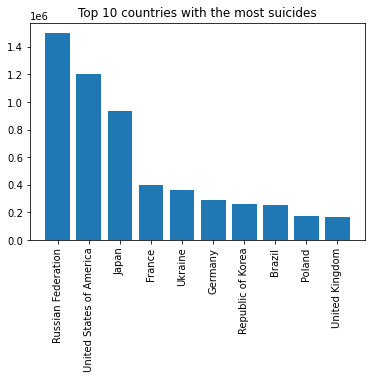

In [12]:
#TOP 10 COUNTRIES WITH THE MOST SUICIDES
countries_df = spark.sql("SELECT country, SUM(suicides_no) AS no_of_suicides from Suicides GROUP BY country ORDER BY SUM(suicides_no) DESC")
countries_df.show(10)

#Bar Chart
x = countries_df.toPandas()["country"].values.tolist()[0:10]
y = countries_df.toPandas()["no_of_suicides"].values.tolist()[0:10]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("Top 10 countries with the most suicides")
plt.show()

+----+--------------+
|year|no_of_suicides|
+----+--------------+
|2002|        259376|
|2003|        259336|
|1999|        258989|
|2000|        258808|
|2001|        254036|
|1998|        252324|
|1996|        249451|
|2009|        246323|
|1995|        245203|
|2004|        244196|
+----+--------------+
only showing top 10 rows



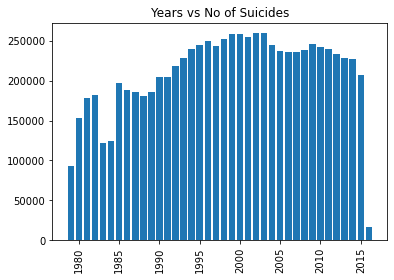

In [13]:
#TOP 10 YEARS WITH THE MOST SUICIDES
years_df = spark.sql("SELECT year, SUM(suicides_no) AS no_of_suicides from Suicides GROUP BY year ORDER BY SUM(suicides_no) DESC")
years_df.show(10)

#Bar Chart
x = years_df.toPandas()["year"].values.tolist()
y = years_df.toPandas()["no_of_suicides"].values.tolist()
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("Years vs No of Suicides")
plt.show()


In [14]:
#TOP 5 COUNTRIES WITH MOST SUICIDES IN 2002
spark.sql("""
SELECT country, year, SUM(suicides_no) AS no_of_suicides from Suicides 
WHERE year = 2002
GROUP BY country, year 
ORDER BY SUM(suicides_no) DESC""").show(5)

+--------------------+----+--------------+
|             country|year|no_of_suicides|
+--------------------+----+--------------+
|  Russian Federation|2002|         55024|
|United States of ...|2002|         31645|
|               Japan|2002|         29715|
|             Ukraine|2002|         12536|
|             Germany|2002|         11176|
+--------------------+----+--------------+
only showing top 5 rows



+------+--------------+
|   sex|no_of_suicides|
+------+--------------+
|  male|       6104173|
|female|       1894294|
+------+--------------+



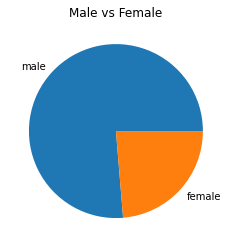

In [15]:
#TOTAL NUMBER OF SUICIDES SEX WISE
sex_df = spark.sql("SELECT sex, SUM(suicides_no) AS no_of_suicides from Suicides GROUP BY sex ORDER BY SUM(suicides_no) DESC")
sex_df.show()

#Pie Chart
x = sex_df.toPandas()["sex"].values.tolist()
y = sex_df.toPandas()["no_of_suicides"].values.tolist()
plt.pie(y, labels = x)
plt.title("Male vs Female")
plt.show()


In [16]:
#TOP 5 COUNTRIES WHERE MALES DIED FROM SUICIDE
spark.sql("""SELECT country, sex, SUM(suicides_no) AS no_of_suicides from Suicides 
WHERE sex = "male" 
GROUP BY country, sex
ORDER BY SUM(suicides_no) DESC""").show(5)

+--------------------+----+--------------+
|             country| sex|no_of_suicides|
+--------------------+----+--------------+
|  Russian Federation|male|       1221474|
|United States of ...|male|        947792|
|               Japan|male|        639281|
|             Ukraine|male|        293561|
|              France|male|        286881|
+--------------------+----+--------------+
only showing top 5 rows



In [17]:
#TOP 5 COUNTRIES WHERE FEMALES DIED FROM SUICIDE
spark.sql("""SELECT country, sex, SUM(suicides_no) AS no_of_suicides from Suicides 
WHERE sex = "female" 
GROUP BY country, sex
ORDER BY SUM(suicides_no) DESC""").show(5)

+--------------------+------+--------------+
|             country|   sex|no_of_suicides|
+--------------------+------+--------------+
|               Japan|female|        298333|
|  Russian Federation|female|        279518|
|United States of ...|female|        253609|
|              France|female|        108619|
|   Republic of Korea|female|         82615|
+--------------------+------+--------------+
only showing top 5 rows



+-----------+--------------+
|        age|no_of_suicides|
+-----------+--------------+
| 5-14 years|         62320|
|  75+ years|        756777|
|15-24 years|        975700|
|25-34 years|       1360780|
|55-74 years|       1955150|
|35-54 years|       2887740|
+-----------+--------------+



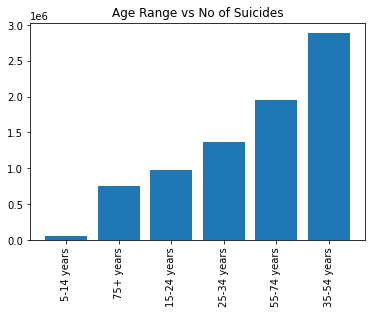

In [18]:
#MOST NUMBER OF SUICIDES BY AGE
age_df = spark.sql("SELECT age, SUM(suicides_no) AS no_of_suicides from Suicides GROUP BY age ORDER BY SUM(suicides_no) ASC")
age_df.show()

#Bar Chart
x = age_df.toPandas()["age"].values.tolist()
y = age_df.toPandas()["no_of_suicides"].values.tolist()
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("Age Range vs No of Suicides")
plt.show()


+------------------+----------------+---------------+--------------------+
|           country|sum(suicides_no)|sum(population)|               ratio|
+------------------+----------------+---------------+--------------------+
|         Lithuania|           42166|      108421714|3.889073364031120...|
|           Hungary|          130018|      368771868|3.525702779475575E-4|
|Russian Federation|         1500992|     4607764120|3.257527861473951E-4|
|         Sri Lanka|           80747|      248810626|3.245319594991895...|
|            Latvia|           24861|       80935340|3.071711319183931E-4|
|           Estonia|           12671|       44051596|2.876399756322109...|
|           Belarus|           74974|      261558592|2.866432313567431...|
|          Slovenia|           16805|       58977219|2.849405293253993...|
|        Kazakhstan|          123151|      475772169|2.588444806657028E-4|
|           Ukraine|          365170|     1474109284|2.477224748283995E-4|
+------------------+-----

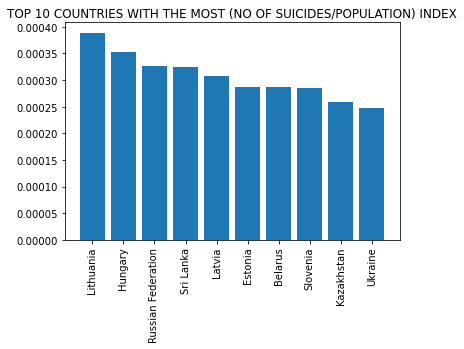

In [19]:
#TOP 10 COUNTRIES WITH THE MOST (NO OF SUICIDES/POPULATION) INDEX
index_df = spark.sql("SELECT country, SUM(suicides_no), SUM(population), SUM(suicides_no)/SUM(population) AS ratio from Suicides GROUP BY country ORDER BY SUM(suicides_no)/SUM(population) DESC")
index_df.show(10)

#Bar Chart
x = index_df.toPandas()["country"].values.tolist()[0:10]
y = index_df.toPandas()["ratio"].values.tolist()[0:10]
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title("TOP 10 COUNTRIES WITH THE MOST (NO OF SUICIDES/POPULATION) INDEX")
plt.show()


In [20]:
#NO OF SUICIDES IN AUSTRALIA
spark.sql("""SELECT country, SUM(suicides_no) as no_of_suicides 
FROM Suicides 
WHERE country = "Australia"
GROUP BY country """).show()

+---------+--------------+
|  country|no_of_suicides|
+---------+--------------+
|Australia|         80279|
+---------+--------------+

